Files already downloaded and verified


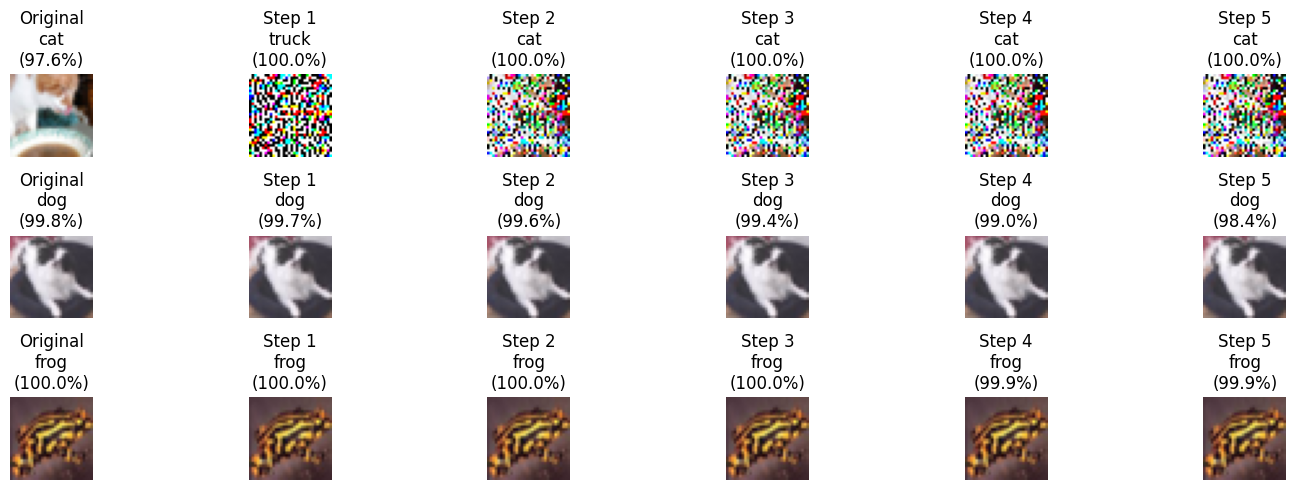

In [7]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Device Setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Define Transforms and Denormalization Function
# -------------------------------
# Using normalization with mean=0.5 and std=0.5 so that pixel values fall in [-1, 1].
norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    norm
])

def denormalize(img_tensor):
    """Convert a normalized tensor back to [0,1] for visualization."""
    return img_tensor * 0.5 + 0.5

# -------------------------------
# Load CIFAR-10 Dataset
# -------------------------------
cifar_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=eval_transform
)

# -------------------------------
# Define and Load Teacher Model
# -------------------------------
# Modified ResNet18 for CIFAR-10.
teacher = torchvision.models.resnet18(weights=None)
teacher.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
teacher.maxpool = nn.Identity()
num_ftrs = teacher.fc.in_features
teacher.fc = nn.Linear(num_ftrs, 10)

# Specify the path to the pre-trained teacher checkpoint.
teacher_checkpoint = "/notebooks/Resnet18/models/cifar10_best_model"

if os.path.exists(teacher_checkpoint):
    teacher_state = torch.load(teacher_checkpoint, map_location=device)
    teacher.load_state_dict(teacher_state)
else:
    print("Warning: Teacher checkpoint not found. Using an untrained teacher model.")

teacher.to(device)
teacher.eval()  # Freeze teacher during adversarial example generation

# -------------------------------
# Helper Function: Teacher Prediction
# -------------------------------
def get_teacher_prediction(image):
    """
    Runs the teacher model on a single image and returns the predicted label index and its confidence.
    
    Args:
        image (torch.Tensor): A normalized image tensor.
        
    Returns:
        pred (int): Predicted label index.
        conf (float): Softmax confidence.
    """
    image = image.to(device)
    with torch.no_grad():
        logits = teacher(image.unsqueeze(0))  # Add batch dimension
        probs = torch.softmax(logits, dim=1)
        conf, pred = torch.max(probs, dim=1)
    return pred.item(), conf.item()

# -------------------------------
# Adaptive Adversarial Trajectory Generation Function
# -------------------------------
def generate_adversarial_trajectory(image, teacher, num_steps=5, default_step_size=0.01, max_logit_drop=0.1):
    """
    Generate a trajectory of adversarial images ensuring that the teacher's top prediction does
    not change too rapidly. In each step, a candidate update is accepted only if the teacher's
    logit for its previously top-predicted class does not drop by more than max_logit_drop.
    
    Args:
        image (torch.Tensor): Original image tensor of shape [C, H, W].
        teacher (torch.nn.Module): The teacher network.
        num_steps (int): Number of iterative updates (i.e. adversarial images to generate).
        default_step_size (float): The initial gradient update step size.
        max_logit_drop (float): Maximum allowed drop in the teacher's top logit between steps.
        
    Returns:
        List[torch.Tensor]: A list of adversarial images generated through the trajectory.
    """
    # Start with a copy of the image.
    x_adv = image.clone().detach().to(device)
    x_adv.requires_grad = True
    adversarial_images = []

    for step in range(num_steps):
        # --- Record teacher's current top prediction and its logit ---
        with torch.no_grad():
            logits_prev = teacher(x_adv.unsqueeze(0))
            top_val_prev, top_class_prev = torch.max(logits_prev, dim=1)  # Record value and index

        # --- Compute the gradient update ---
        # Here we use the negative of the second highest logit as our loss.
        logits = teacher(x_adv.unsqueeze(0))
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        # The class with the second-highest logit.
        target_class = sorted_indices[0, 1]
        loss = -logits[0, target_class]

        teacher.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.zero_()
        loss.backward()

        # Use the sign of the gradient as the update direction.
        grad_sign = x_adv.grad.sign()

        # --- Adaptive step-size control ---
        current_step_size = default_step_size
        candidate_found = False
        candidate = None
        while not candidate_found:
            # Compute candidate update from current image.
            candidate = x_adv - current_step_size * grad_sign
            # Evaluate teacher output for candidate image on previous top class.
            with torch.no_grad():
                logits_candidate = teacher(candidate.unsqueeze(0))
                candidate_top_logit = logits_candidate[0, top_class_prev]
            # Measure the drop in the teacher's top logit.
            drop = top_val_prev.item() - candidate_top_logit.item()
            if drop > max_logit_drop:
                # Too big a drop: reduce step size and try again.
                current_step_size = current_step_size / 2.0
            else:
                candidate_found = True

        # Accept candidate update.
        x_adv = candidate.clone().detach()
        x_adv.requires_grad = True
        adversarial_images.append(x_adv)

    return adversarial_images

# -------------------------------
# Expose Hyperparameters for the Attack
# -------------------------------
num_attack_steps = 5         # Number of gradient steps.
default_attack_step_size = 5  # Default step size for gradient update.
max_logit_drop_threshold = 0.3   # Maximum allowed drop in top logit between steps.

# -------------------------------
# Generate Adversarial Trajectories for Some Samples
# -------------------------------
# Randomly select a few examples for demonstration.
num_samples_to_show = 3
sample_indices = np.random.choice(len(cifar_dataset), num_samples_to_show, replace=False)

original_images = []
trajectories = []  # Each element is a list of adversarial images (one trajectory per sample)
sample_labels = []

for idx in sample_indices:
    img, label = cifar_dataset[idx]
    original_images.append(img)
    sample_labels.append(label)
    adv_traj = generate_adversarial_trajectory(
        img, teacher, num_steps=num_attack_steps,
        default_step_size=default_attack_step_size,
        max_logit_drop=max_logit_drop_threshold
    )
    trajectories.append(adv_traj)

# -------------------------------
# Visualization: Plot Images with Teacher Predictions & Confidence
# -------------------------------
# CIFAR-10 class names.
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(num_samples_to_show, num_attack_steps + 1, figsize=(15, 5))
for i in range(num_samples_to_show):
    # Visualize original image.
    orig_img = denormalize(original_images[i]).clamp(0, 1).permute(1, 2, 0).cpu().numpy()
    pred, conf = get_teacher_prediction(original_images[i])
    teacher_info = f"{cifar_classes[pred]}\n({conf*100:.1f}%)"
    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title("Original\n" + teacher_info)
    axes[i, 0].axis("off")
    
    # Visualize each adversarial step.
    for j in range(num_attack_steps):
        adv_img = denormalize(trajectories[i][j].detach()).clamp(0, 1).permute(1, 2, 0).cpu().numpy()
        pred_adv, conf_adv = get_teacher_prediction(trajectories[i][j])
        teacher_info_adv = f"{cifar_classes[pred_adv]}\n({conf_adv*100:.1f}%)"
        axes[i, j+1].imshow(adv_img)
        axes[i, j+1].set_title(f"Step {j+1}\n" + teacher_info_adv)
        axes[i, j+1].axis("off")

plt.tight_layout()
plt.show()
